In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [10]:
Path.cwd()

PosixPath('/home/nur/Projects/vut-ip1-nn-quantization/src/notebooks')

In [2]:
from src.nas.mlp_chromosome import RawChromosome


low, high = RawChromosome.get_bounds()
low, high

(array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 8, 7, 8, 7, 8, 7, 2, 3, 3, 1, 1, 6, 3]))

In [3]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas import MlpNasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset


DatasetClass = VertebralDataset
params = MlpNasParams(
    epochs=20,
    patience=5,
    amount_of_evaluations=20,
    population_size=50,
    population_offspring_count=20,
    algorithm_generations=5,
    population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

INFO: Loading cached vertebral from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl
INFO: Loading cached breast_cancer from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/breast_cancer_cache.pkl


(162.0, np.float64(2160.0))

In [4]:
plow = problem.get_nn_params(RawChromosome(low).parse())
phigh = problem.get_nn_params(RawChromosome(high).parse())

problem.compute_nn_complexity(plow), problem.compute_nn_complexity(phigh)

(162.0, np.float64(2160.0))

In [5]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file is empty. Using random sampling


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      1 |             - |             -
     2 |       70 |      2 |  0.000000E+00 |             f
     3 |       90 |      3 |  1.0000000000 |         ideal
     4 |      110 |      5 |  0.000000E+00 |             f
     5 |      130 |      8 |  0.000000E+00 |             f
Solutions: [[2 0 7 4 8 3 8 2 0 1 3 0 1 6 0]
 [2 0 6 1 4 0 8 0 0 1 3 0 0 6 0]
 [4 0 6 4 1 7 7 3 0 0 2 0 0 5 2]
 [2 0 6 4 1 0 8 3 1 1 3 0 0 6 0]
 [2 0 4 1 5 2 8 6 0 1 3 0 0 6 0]
 [3 0 6 1 4 0 8 0 0 1 3 0 0 6 0]
 [3 0 4 6 5 2 2 6 0 2 3 0 1 6 3]
 [2 0 6 0 8 0 8 0 0 1 3 0 0 6 0]]
Objectives: [[-0.87096774  0.          0.        ]
 [-0.87096774  0.          0.        ]
 [-0.88709677  0.10718336  0.03571429]
 [-0.87096774  0.          0.        ]
 [-0.87096774  0.          0.        ]
 [-0.87096774  0.          0.        ]
 [-0.87096774  0.          0.        ]
 [-0.87096774  0.          0.        ]]


In [11]:
from dataclasses import asdict

from pprint import pprint
import pandas as pd
from pymoo.core.result import Result


def res_to_df(res: Result) -> pd.DataFrame:
    data = []
    for i in range(len(res.X)):
        x = res.X[i]
        f = res.F[i]
        accuracy = problem.denormalize(-f[0], 0, 100)
        complexity = problem.denormalize(
            f[1], problem.get_min_complexity(), problem.get_max_complexity()
        )

        ch = RawChromosome(x).parse()
        params = problem.get_nn_params(ch)

        data.append(
            {
                "Accuracy": accuracy,
                "Complexity": complexity,
                **asdict(params),
                "Chromosome": x,
            }
        )

    return pd.DataFrame(data)


df = res_to_df(res)
df

,Accuracy,Complexity,in_height,out_height,hidden_layers,hidden_layers_heights,hidden_layers_bitwidths,in_bitwidth,activation,reste_o,reste_threshold,dropout_rate,learning_rate,weight_decay,epochs,quantization_mode,Chromosome
0,87.096774,162.000000,6,3,0,"[7, 8, 8]","[5, 4, 3]",3,ActivationModule.BINARIZE_RESTE,1.5,1,0.0,0.010,0.010,20,QMode.DET,"[2, 0, 7, 4, 8, 3, 8, 2, 0, 1, 3, 0, 1, 6, 0]"
1,87.096774,162.000000,6,3,0,"[6, 4, 8]","[2, 1, 1]",3,ActivationModule.BINARIZE_RESTE,1.5,1,0.0,0.010,0.010,20,QMode.DET,"[2, 0, 6, 1, 4, 0, 8, 0, 0, 1, 3, 0, 0, 6, 0]"
2,88.709677,376.152351,6,3,0,"[6, 1, 7]","[5, 8, 4]",5,ActivationModule.RELU,1.5,1,0.0,0.005,0.002,20,QMode.DET,"[4, 0, 6, 4, 1, 7, 7, 3, 0, 0, 2, 0, 0, 5, 2]"
3,87.096774,162.000000,6,3,0,"[6, 1, 8]","[5, 1, 4]",3,ActivationModule.BINARIZE_RESTE,1.5,1,0.1,0.010,0.010,20,QMode.DET,"[2, 0, 6, 4, 1, 0, 8, 3, 1, 1, 3, 0, 0, 6, 0]"
4,87.096774,162.000000,6,3,0,"[4, 5, 8]","[2, 3, 7]",3,ActivationModule.BINARIZE_RESTE,1.5,1,0.0,0.010,0.010,20,QMode.DET,"[2, 0, 4, 1, 5, 2, 8, 6, 0, 1, 3, 0, 0, 6, 0]"
5,87.096774,162.000000,6,3,0,"[6, 4, 8]","[2, 1, 1]",4,ActivationModule.BINARIZE_RESTE,1.5,1,0.0,0.010,0.010,20,QMode.DET,"[3, 0, 6, 1, 4, 0, 8, 0, 0, 1, 3, 0, 0, 6, 0]"
6,87.096774,162.000000,6,3,0,"[4, 5, 2]","[7, 3, 7]",4,ActivationModule.BINARIZE,1.5,1,0.0,0.010,0.001,20,QMode.DET,"[3, 0, 4, 6, 5, 2, 2, 6, 0, 2, 3, 0, 1, 6, 3]"
7,87.096774,162.000000,6,3,0,"[6, 8, 8]","[1, 1, 1]",3,ActivationModule.BINARIZE_RESTE,1.5,1,0.0,0.010,0.010,20,QMode.DET,"[2, 0, 6, 0, 8, 0, 8, 0, 0, 1, 3, 0, 0, 6, 0]"


In [12]:
ch = RawChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(in_height=6,
          out_height=3,
          hidden_layers=np.int64(0),
          hidden_layers_heights=[np.int64(7), np.int64(8), np.int64(8)],
          hidden_layers_bitwidths=[5, 4, 3],
          in_bitwidth=3,
          activation=<ActivationModule.BINARIZE_RESTE: 'binary_ReSTE'>,
          reste_o=1.5,
          reste_threshold=1,
          dropout_rate=0.0,
          learning_rate=0.01,
          weight_decay=0.01,
          epochs=20,
          quantization_mode=<QMode.DET: 'det'>)


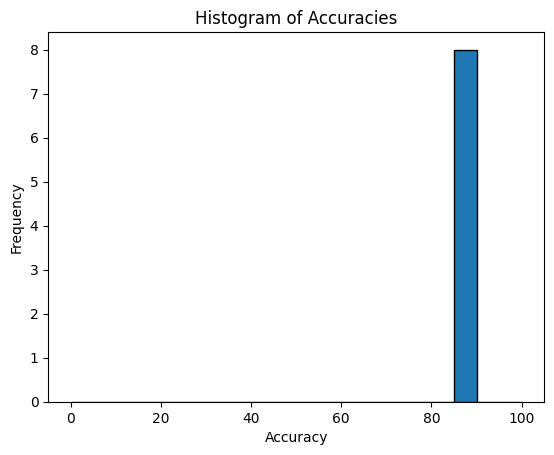

In [15]:
from matplotlib import pyplot as plt

from src.models.mlp import MLPEvaluator


def hist_accuracies(accuracies: list[float], bins=20) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=bins, range=(0, 100), edgecolor="black")
    ax.set_title("Histogram of Accuracies")
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("Frequency")
    return fig


fig = hist_accuracies(df["Accuracy"])

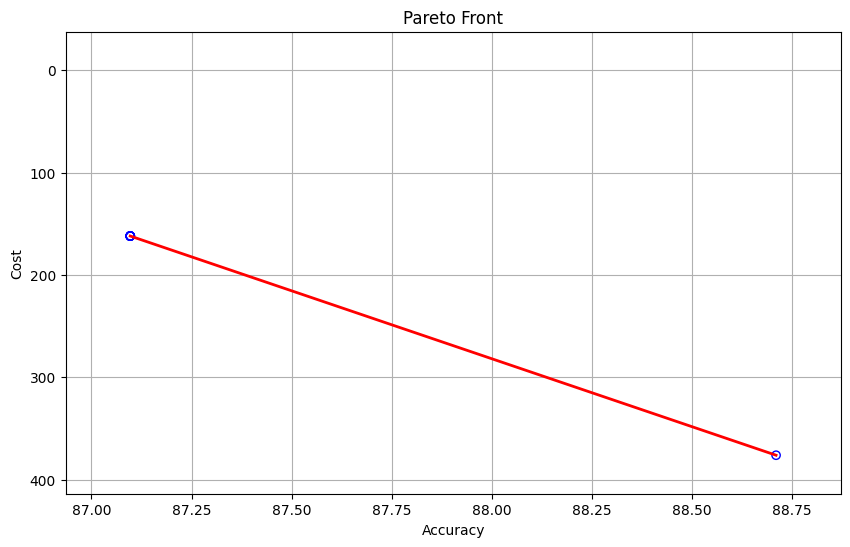

In [16]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])